In [59]:
import numpy as np
import pandas as pd 
import random
import torch

import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import glob
import shutil

import os
import warnings
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

Seed

In [7]:
SEED = 42

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Вид данных

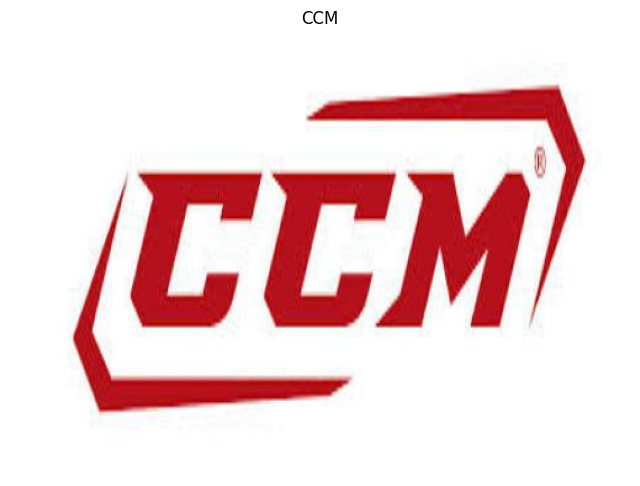

In [12]:
example_image_path = '/kaggle/input/logodet3k/LogoDet-3K/Sports/CCM/1.jpg'

def visualize_data(img_path:str = example_image_path):
    '''Функция принимает путь и строит по нему изображение при помощи PIL

    Параметры:
    -img_path: путь к изображению (str, default: example_image_path)
    '''
    try:
        img = Image.open(img_path)
        brand_name = os.path.basename(os.path.dirname(img_path))
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')  
        plt.title(f"{brand_name}")
        plt.show()
    except FileNotFoundError:
        print(f"File not found: {img_path}")
    except Exception as e:
        print(f"Error occured: {e}")

visualize_data()

Далее нужно распаковать .xml файл для анализа его содержимого

In [14]:
example_xml_path = '/kaggle/input/logodet3k/LogoDet-3K/Sports/CCM/1.xml'

def parse_xml(xml_path:str = example_xml_path):
    '''
    Функция для осуществления парсинга .xml файла для анализа его содержимого
    
    Параметры:
    -xml_path: путь к файлу .xml (str, default: example_xml_path)
    '''
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        folder = root.find('folder').text
        filename = root.find('filename').text
        size = {
            'width': int(root.find('./size/width').text),
            'height': int(root.find('./size/height').text),
            'depth': int(root.find('./size/depth').text)
        }
        segmented = int(root.find('segmented').text)
        
        objects = []
        for obj in root.findall('object'):
            obj_data = {
                'name': obj.find('name').text,
                'pose': obj.find('pose').text,
                'truncated': int(obj.find('truncated').text),
                'difficult': int(obj.find('difficult').text),
                'bndbox': {
                    'xmin': int(obj.find('./bndbox/xmin').text),
                    'ymin': int(obj.find('./bndbox/ymin').text),
                    'xmax': int(obj.find('./bndbox/xmax').text),
                    'ymax': int(obj.find('./bndbox/ymax').text)
                }
            }
            objects.append(obj_data)
        
        return {
            'folder': folder,
            'filename': filename,
            'size': size,
            'segmented': segmented,
            'objects': objects
        }
    except FileNotFoundError:
        print(f"Файл {file_path} не найден.")
    except ET.ParseError as e:
        print(f"Ошибка парсинга XML: {e}")
    except Exception as e:
        print(f"Произошла ошибка: {e}")

result = parse_xml()
print(result)
    

{'folder': 'VOC2007', 'filename': '1.jpg', 'size': {'width': 503, 'height': 360, 'depth': 3}, 'segmented': 0, 'objects': [{'name': 'CCM', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bndbox': {'xmin': 87, 'ymin': 81, 'xmax': 432, 'ymax': 258}}]}


Скорее всего, для crop нас будут интересовать поля 'name' (бренд), 'bndbox' (bounding box)

Дополнительно, возможно, есть смысл обратить внимания на поля 'truncated' (был ли обрезан объект), 'size' (размеры), 'difficult' (что-то вроде сложности распознавания). Например, есть смысл использовать поле 'difficult' для дообучения после первого запуска для более лучшей метрики на сложоклассифицируемых данных.

Предварительные шаги для решения задачи:

1. Собрать искомый датасет в формате "путь к изображению, атрибуты из .xml, метка бренд, метка логотип"

2. Обучить модель находить логотип на изображении (например, YOLO или Faster-RCNN). Решить задачу Object Detection

3. Решить задачу Metric Learning для сближения похожих логотипов. (Или использовать косинусную близость в качестве простого случая)

4. Дополнительно использовать модели распознавания текста на изображении (EAST, например) с доработкой или шлифовкой текста через запрос в языковую модель (GPT-like).

Таким образом, оценочное решение может состоять из детекции объекта на изображении (например, кадре видео) и выводу о том, соответствует ли он представленной серии логотипов определенного бренда.

Итак, первым шагом необходимо собрать датасет

In [ ]:
DIR_PATH = '/kaggle/input/logodet3k/LogoDet-3K'

def create_logo_dataset(directory_path:str = DIR_PATH):
    '''
    Функция для создания искомого датасета по заданному каталогу изображений и аннотаций к ним

    Параметры:
    -directory_path: путь к каталогу изображений и аннотаций к ним
    '''
    images_annotations = {}
    for i, data in enumerate(tqdm(os.walk(directory_path))):
        root, _, files = data
        
        jpg_files = [f for f in files if f.endswith('.jpg')]
        xml_files = [f for f in files if f.endswith('.xml')]
    
        for jpg_file in jpg_files:
            jpg_path = os.path.join(root, jpg_file)
            xml_path = os.path.join(root, jpg_file.replace('.jpg', '.xml'))
            if os.path.basename(xml_path) in xml_files:
                parsing_result = parse_xml(xml_path)
                images_annotations[jpg_path] = {
                    'xml_path' : xml_path, 
                    'truncated': parsing_result['objects'][0]['truncated'],
                    'difficult': parsing_result['objects'][0]['difficult'],
                    'bbox': parsing_result['objects'][0]['bndbox'],
                    'size': parsing_result['size']
                    }
    return images_annotations
    # pass

# logo_dataset = create_logo_dataset()

Работает очень долго

In [61]:
logo_dataset = pd.DataFrame(glob.glob(f"{DIR_PATH}/*/*/*"), columns=["file_path"])
logo_dataset["extension"] = logo_dataset["file_path"].apply(lambda x: x.split(".")[-1])
logo_dataset["logo_category"] = logo_dataset["file_path"].apply(lambda x: x.split(os.sep)[-3])
logo_dataset["logo_name"] = logo_dataset["file_path"].apply(lambda x: x.split(os.sep)[-2])
logo_dataset.head()

,file_path,extension,logo_category,logo_name
0,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
1,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
2,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
3,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery
4,/kaggle/input/logodet3k/LogoDet-3K/Leisure/Art...,jpg,Leisure,Artillery


Проверка соответствия .xml и .jpg

In [62]:
logo_dataset["extension"].value_counts()

extension
jpg    158654
xml    158654
Name: count, dtype: int64

In [63]:
logo_dataset['logo_category'].unique()

array(['Leisure', 'Sports', 'Necessities', 'Medical', 'Electronic',
       'Clothes', 'Transportation', 'Food', 'Others'], dtype=object)

Немного статистики по данным

In [76]:
logo_dataset["logo_category"].value_counts()

logo_category
Food              106700
Clothes            62532
Necessities        49644
Others             31026
Transportation     20890
Electronic         19350
Leisure            11370
Sports              7906
Medical             7890
Name: count, dtype: int64

In [72]:
mean_logo_per_category = logo_dataset.groupby("logo_category")["file_path"].count().mean()
mean_logo_per_brand = logo_dataset.groupby("logo_name")['file_path'].count().mean()
max_logo_per_brand = logo_dataset.groupby("logo_name")['file_path'].count().max()
min_logo_per_brand = logo_dataset.groupby("logo_name")['file_path'].count().min()
print(f"Среднее число лого на категорию: {mean_logo_per_category:.2f}")
print(f"Среднее число лого на бренд: {mean_logo_per_brand:.2f}")
print(f"Максимальное число лого на бренд: {max_logo_per_brand:.2f}")
print(f"Минимальное число лого на бренд: {min_logo_per_brand:.2f}")

Среднее число лого на категорию: 35256.44
Среднее число лого на бренд: 105.77
Максимальное число лого на бренд: 604.00
Минимальное число лого на бренд: 8.00


Распределение лого по брендам

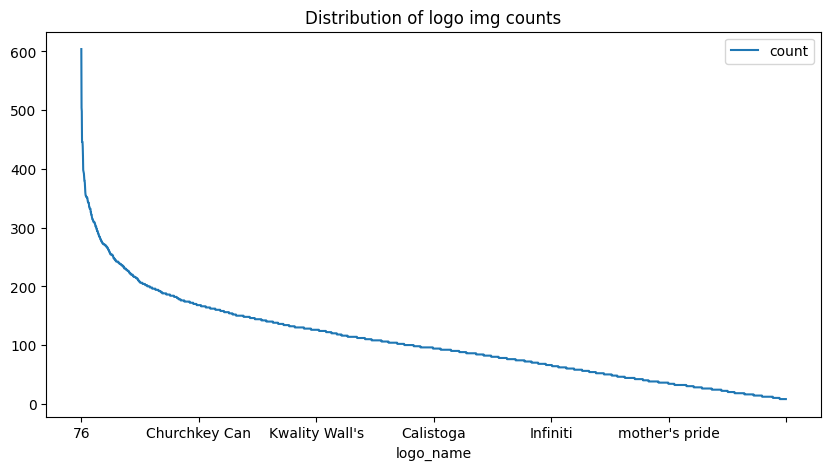

In [82]:
logo_dataset["logo_name"].value_counts().reset_index().plot(
    x="logo_name", y="count", figsize=(10,5), title="Distribution of logo img counts")
plt.show()

Зная данные распределения и внутреннюю аналитику сервиса VK Video можно неплохо отредактировать данный датасет. К сожалению, эти данные невозможно найти в открытом доступе, однако располагая ими можно осуществить следующие шаги:

1. Можно проанализировать статистику рекламы в видеороликах. Например, по ссылкам, оставленным в описании при помощи NLP и Name (Link) Entity Recognition - это характерно для нативной рекламы. Или взять другие подобные атрибуты. Имея представление о распределении случаев рекламы по категорям можно сделать вывод о трендах и категориях продуктов, рекламу которых преимуществнно размещают пользователи в своих видео. Так, обладая данной информацией, можно отбросить категории, представленные в готовом датасете.

2. В соответствии с правилами [правилами о размещении рекламы](https://ads.vk.com/help/articles/moderation) можно сделать вывод о невозможности размещения каких-либо продуктов. Хотя с другой стороны, распознавание брендов может помочь как раз-таки в детекции этих самых объектов для дальнейшей модерации.

Например, полагая, что Медицинские препараты не являются популярной опцией для рекламы в VK Video ввиду разных целевых аудиторий, можно отбросить данную категорию (Хотя здесь их в принципе мало, всего ~7800 сэмплов, поэтому можно и без них обойтись).

Вероятно, логотипы часто имеют буквенную форму записи, что делает задачу детекции более простой и не требует полного датасета для её решения